In [1]:
import pandas as pd
import re
import itertools
from  matplotlib import pyplot as plt
import networkx as nx
import collections
import warnings
import os
warnings.filterwarnings('ignore')
os.chdir('C:\\Users\\steven.ellingson\\PycharmProjects\\cuny')

I was able to get a dataset of movies from Kaggle. https://www.kaggle.com/rounakbanik/the-movies-dataset
I plan to make a graph using the genres from this dataset, to see how often certain genres overlap for the same movie.
First I'll load the data:

In [2]:
movies = pd.read_csv('data/movies_metadata.csv')
movies.dtypes

adult                       bool
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
id                         int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                    int64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                       bool
vote_average             float64
vote_count                 int64
dtype: object

The genres are stored in a strange way, similar to JSON but different enough that none of the JSON packages seem to work.

Luckily I wrote a script to extract it last semester!

In [3]:
genres = pd.DataFrame(columns = ('movie_id','genre_id', 'name'))
temp_genre = pd.DataFrame(columns = ('movie_id','genre_id', 'name'))

pattern = re.compile(r"'id'\: (\d{1,9}), 'name'\: '((?:[^'\\]|\\.)*)'")
temp_row_count = 0
row_limit = 100000 # Use this for development/testing 

for i,row in movies.iterrows():
    reg = re.findall(pattern, row['genres'])
    for row2 in reg:
        temp_genre = temp_genre.append({'movie_id': row['id'], 'genre_id': row2[0], 'name': row2[1]}, ignore_index=True)
    if (temp_row_count > 1000):
        genres = genres.append(temp_genre)
        temp_genre = pd.DataFrame(columns = ('movie_id','genre_id', 'name'))
        temp_row_count = 0
        print (str(i) + ' rows completed, ' + str(round(i/len(movies)*100,1)) + '% done')
    temp_row_count = temp_row_count+1
    if i > row_limit:
        break
    

genres = genres.append(temp_genre)     
genres.head()



1001 rows completed, 2.2% done
2002 rows completed, 4.4% done
3003 rows completed, 6.6% done
4004 rows completed, 8.8% done
5005 rows completed, 11.0% done
6006 rows completed, 13.2% done
7007 rows completed, 15.4% done
8008 rows completed, 17.6% done
9009 rows completed, 19.8% done
10010 rows completed, 22.0% done
11011 rows completed, 24.2% done
12012 rows completed, 26.4% done
13013 rows completed, 28.6% done
14014 rows completed, 30.8% done
15015 rows completed, 33.0% done
16016 rows completed, 35.2% done
17017 rows completed, 37.4% done
18018 rows completed, 39.6% done
19019 rows completed, 41.8% done
20020 rows completed, 44.0% done
21021 rows completed, 46.2% done
22022 rows completed, 48.4% done
23023 rows completed, 50.6% done
24024 rows completed, 52.8% done
25025 rows completed, 55.0% done
26026 rows completed, 57.2% done
27027 rows completed, 59.4% done
28028 rows completed, 61.7% done
29029 rows completed, 63.9% done
30030 rows completed, 66.1% done
31031 rows completed, 6

,movie_id,genre_id,name
0,862,16,Animation
1,862,35,Comedy
2,862,10751,Family
3,8844,12,Adventure
4,8844,14,Fantasy


OK so there are 91k genre/movie combos here. 
Let's see if we can sum up the combinations into a frequency distribution.


In [4]:
full_list = list()
for movie_id in genres['movie_id'].unique():
    movie_genres = list(genres[genres.movie_id==movie_id].name)
    movie_genres.sort()
    genre_combinations = (set(list(itertools.combinations(movie_genres, 2))))
    combination_list = [','.join(lst) for lst in genre_combinations]
    full_list.extend(combination_list)
    
fd=collections.Counter(full_list)
df = pd.DataFrame(list(fd.items()),columns = ['genre_combo','freq']) 
df = df[~df['genre_combo'].str.match(r'(.*),\1')]
df = df.sort_values('freq')
df.head()

,genre_combo,freq
206,"Foreign,TV Movie",2
207,"History,Science Fiction",4
205,"Documentary,Western",4
194,"Foreign,Western",7
176,"Animation,Western",7


In [5]:
df.tail()

,genre_combo,freq
12,"Crime,Drama",2522
6,"Comedy,Romance",3116
14,"Drama,Thriller",3425
8,"Comedy,Drama",4186
7,"Drama,Romance",4483


We can see the more and less strong relationships.
Unsurprisingly, Science Fiction and History don't go together very often.  Just 4 movies. 
Let's see what they are! 

In [6]:
movies[movies['id'].isin(genres[genres['name']=='History'].movie_id) & movies['id'].isin(genres[genres['name']=='Science Fiction'].movie_id)][['title','tagline']]

,title,tagline
18208,Hanussen,He saw the future. And it was war.
19977,Kung Fu Cult Master,NaN
25058,Iceman,NaN
40779,Capsule,"One Man, One Mission, One Choice"


Never heard of any of those, but I am intrigued.

OK, lets try to build a graph with these.

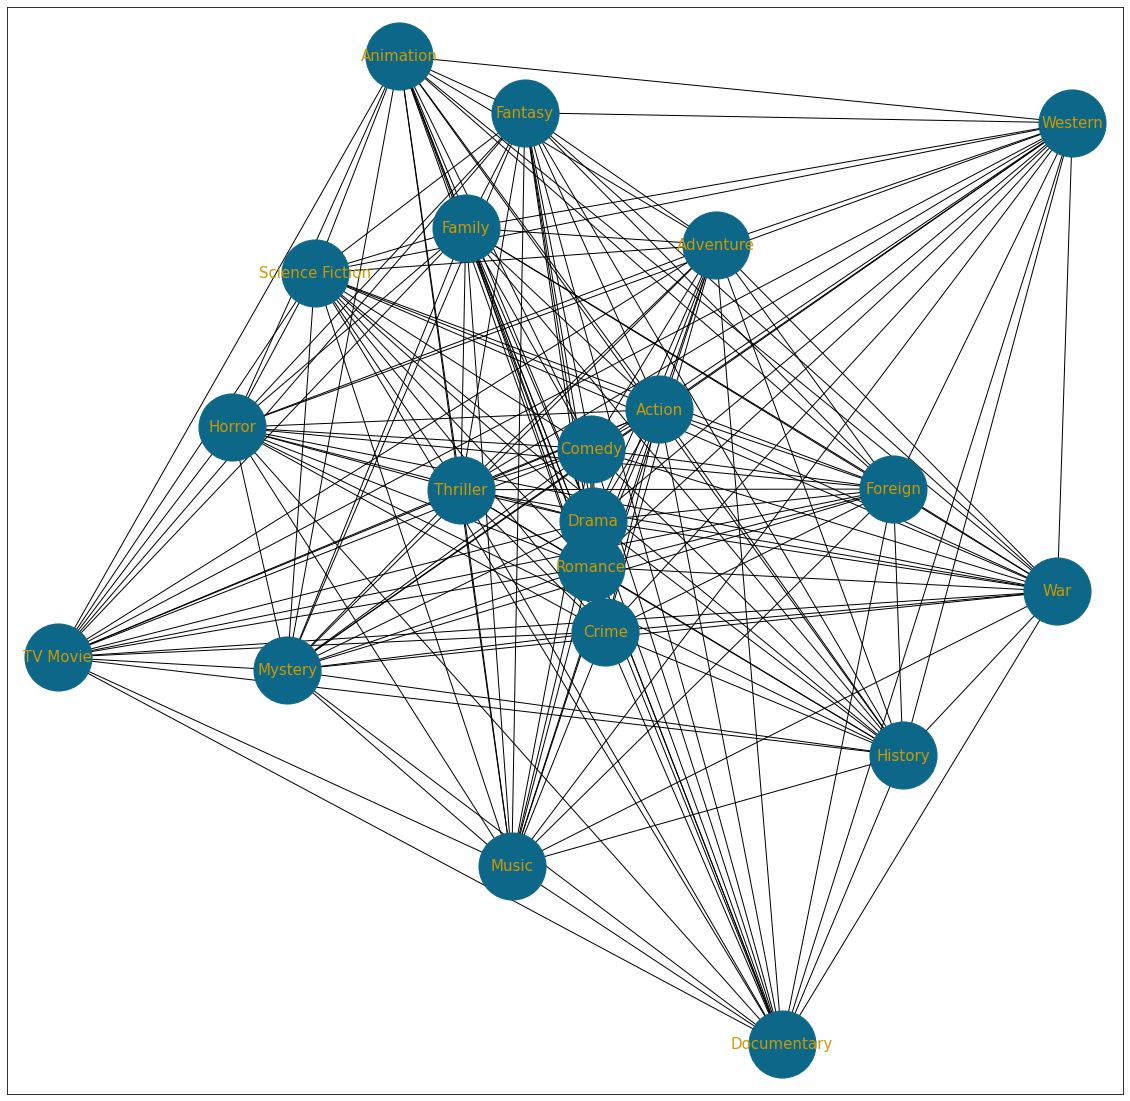

In [7]:
plt.figure(figsize=(20,20))
G=nx.Graph()
G.add_weighted_edges_from((df['genre_combo']+ ',' + df['freq'].astype(str)).str.split(','))
nx.draw_networkx(G, with_labels=True,
                 node_size = 4500,
                 node_color = '#0C6788',
                 font_size = 15,
                 font_color = '#cc9900'
                 )
plt.show()


Interesting! Though seeing Action/Comedy/Drama/Adventure all stacked together in the middle makes me think this has more to do with overall frequency than with connections.
Let's create a "relative frequency" that is normalizes by how frequent the genres are in general.

In [8]:
df['rel_freq'] = 0
for i, row in df.iterrows():
    genre_list = row['genre_combo'].split(',')
    freq =  sum(genres['name']==genre_list[0])
    freq = freq + sum(genres['name']==genre_list[1])
    df.loc[i,'rel_freq'] = row['freq']/freq*2
df = df.sort_values('rel_freq')
df.head()

,genre_combo,freq,rel_freq
205,"Documentary,Western",4,0.001608
206,"Foreign,TV Movie",2,0.001674
207,"History,Science Fiction",4,0.001799
200,"Documentary,Fantasy",8,0.002562
132,"Documentary,Thriller",26,0.004500


In [9]:
df.tail()

,genre_combo,freq,rel_freq
7,"Drama,Romance",4483,0.332074
11,"Action,Thriller",2370,0.333333
10,"Crime,Thriller",2014,0.337608
15,"Action,Adventure",1730,0.342846
0,"Animation,Family",855,0.363443


Looks like this made a difference. Now Animation/Family is at the top of the list, despite being nowhere near the top overall.

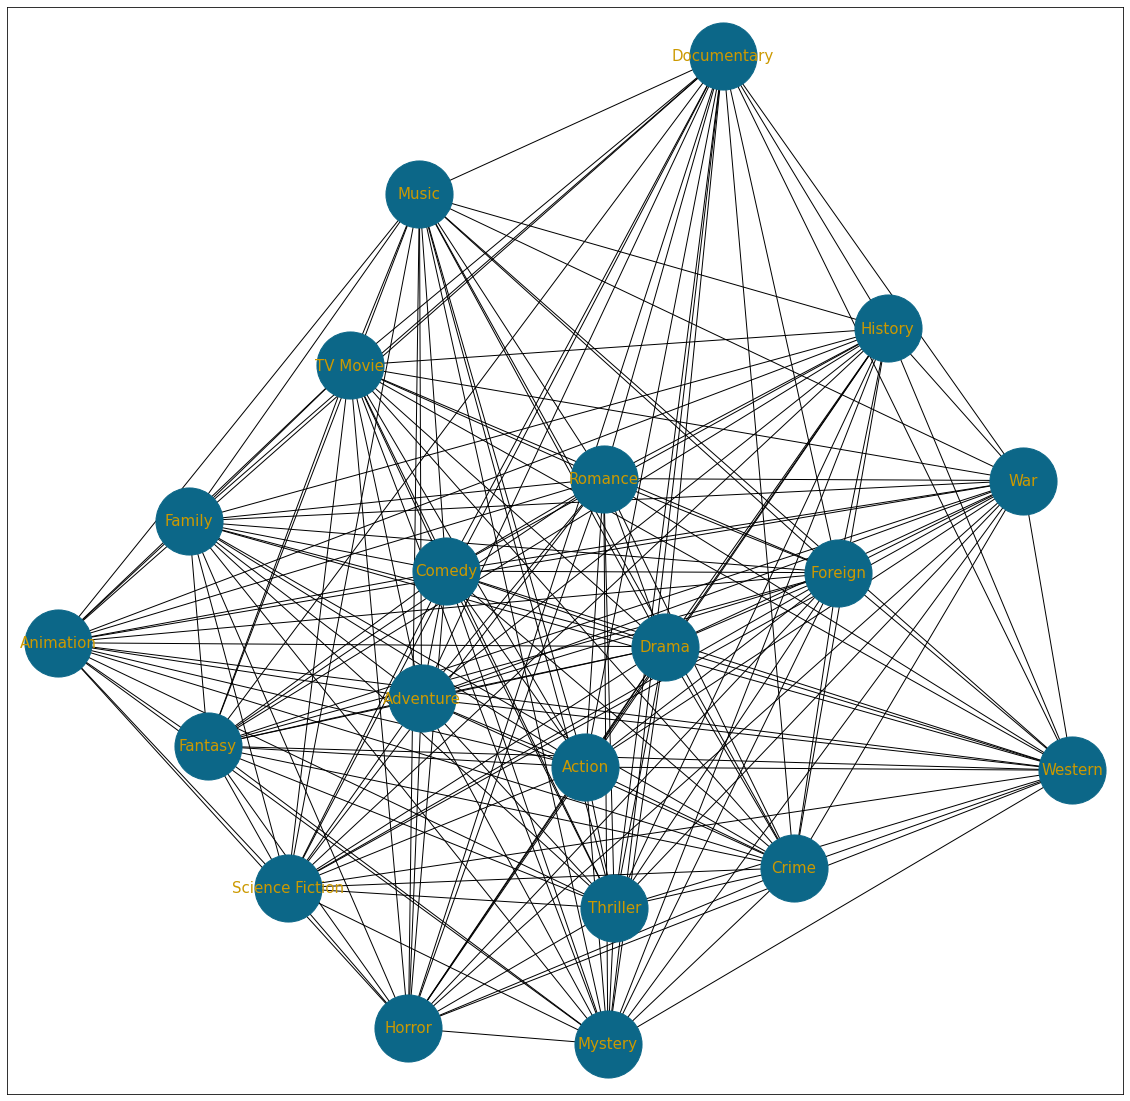

In [10]:
plt.figure(figsize=(20,20))
G=nx.Graph()
G.add_weighted_edges_from((df['genre_combo']+ ',' + df['rel_freq'].astype(str)).str.split(','))
nx.draw_networkx(G, with_labels=True,
                 node_size = 4500,
                 node_color = '#0C6788',
                 font_size = 15,
                 font_color = '#cc9900'
                 )
plt.show()

Alright, so this looks very interesting.  You still have the more "general" groups in the center, but the proximities make more sense.  